In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd drive/MyDrive/Sapienza/DL

/content/drive/MyDrive/Sapienza/DL


In [3]:
import pickle
import pandas as pd
import numpy as np
import json
import itertools
import gensim
path="SEMEVAL-2021-task6-corpus/data/"


In [4]:
with open('training_task3_images.pkl', 'rb') as handle:
    images = pickle.load(handle)

with open('training_task3_texts.pkl', 'rb') as handle:
    texts = pickle.load(handle)

with open('training_task3_labels_onehot.pkl', 'rb') as handle:
    train_labs = pickle.load(handle)

with open('training_task3_labels_string.pkl', 'rb') as handle:
    train_labs_str = pickle.load(handle)

with open('task3_all_labels.pkl', 'rb') as handle:
    all_labs = pickle.load(handle)



with open('dev_task3_images.pkl', 'rb') as handle:
    dev_images = pickle.load(handle)

with open('dev_task3_texts.pkl', 'rb') as handle:
    dev_texts = pickle.load(handle)

with open('dev_task3_labels_onehot.pkl', 'rb') as handle:
    dev_labs = pickle.load(handle)

with open('dev_task3_labels_string.pkl', 'rb') as handle:
    dev_labs_str = pickle.load(handle)



In [5]:
!nvidia-smi

Fri Feb 18 21:55:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [7]:
!pip3 install tensorflow-addons


In [8]:
num_classes = len(all_labs)
input_shape = images.shape[1:]
input_shape

(224, 224, 3)

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 100  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 6
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [10]:
x_train=images

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [51]:
count=0
def mlp(x, hidden_units, dropout_rate):
    global count
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, name='feats'+str(count))(x)
        x = layers.Dropout(dropout_rate)(x)
        count+=1
    return x

In [52]:
count

0

In [40]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 100 X 100
Patch size: 6 X 6
Patches per image: 256
Elements per patch: 108


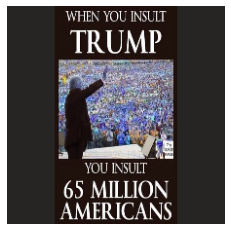

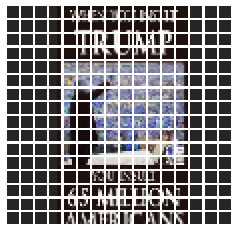

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [33]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [53]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    j=0
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.2)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])
        j+=1

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.2)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.4)
    # Classify outputs.
    logits = layers.Dense(num_classes,activation='sigmoid')(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [42]:
x_test=dev_images
y_test=dev_labs
y_train=train_labs

In [54]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    model.summary()
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            "categorical_accuracy"
        ]
    )


    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=[x_test,y_test]
    )

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  7          ['input_6[0][0]']                
                                                                                                  
 patches_7 (Patches)            (None, None, 108)    0           ['data_augmentation[5][0]']      
                                                                                                  
 patch_encoder_5 (PatchEncoder)  (None, 256, 64)     23360       ['patches_7[0][0]']        

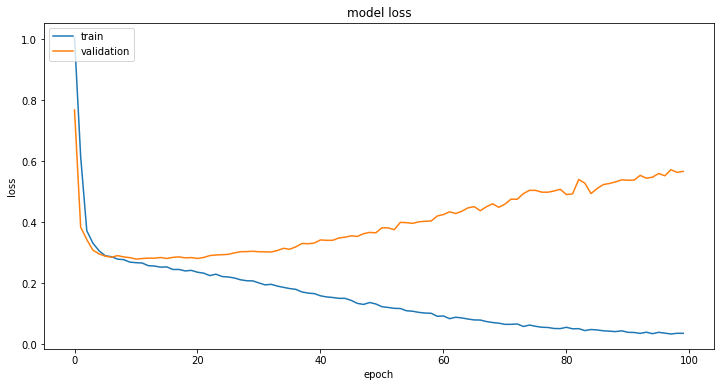

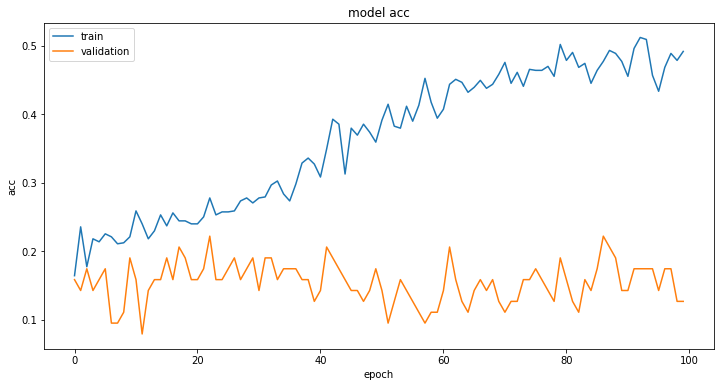

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline


# plotting the validation and training loss i.e. "mean absolute error"
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.figure(figsize=(12,6))

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])

plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [56]:
from keras.models import Model

feature_network = Model(vit_classifier.input, vit_classifier.get_layer('feats13').output)
X_train = feature_network.predict(images)

X_train.shape

(687, 1024)

In [57]:
X_valid = feature_network.predict(dev_images)
X_valid.shape

(63, 1024)

In [58]:
y_train=train_labs
y_valid=dev_labs

In [59]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 10, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.047619047619047616
Weighted F1 score:  0.3853497379813169
Micro F1 score:  0.4409937888198758
Macro F1 score:  0.11341198846919669


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [60]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 1, penalty='l2', solver = 'liblinear', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.047619047619047616
Weighted F1 score:  0.4012941820069781
Micro F1 score:  0.45562130177514787
Macro F1 score:  0.12460731641304429


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [61]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(C = 20, penalty='l2', solver = 'lbfgs', random_state=42)

one_vs_rest = OneVsRestClassifier(log_reg)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.2) 
y_train_new=(y_train > 0.2) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.2) 
y_dev_new=(y_valid > 0.2) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

from sklearn.metrics import classification_report, f1_score

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.047619047619047616
Weighted F1 score:  0.38444516180889926
Micro F1 score:  0.45425867507886436
Macro F1 score:  0.11385600905840784


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [62]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier(n_estimators=60,n_jobs=-1)

one_vs_rest = OneVsRestClassifier(rnd)
one_vs_rest.fit(X_train, y_train)

y_train_pred_proba = one_vs_rest.predict_proba(X_train)
y_valid_pred_proba = one_vs_rest.predict_proba(X_valid)

y_pred = (y_train_pred_proba > 0.3) 
y_train_new=(y_train > 0.3) 

print("Training accuracy: ", accuracy_score(y_train_new, y_pred))

y_pred1 = (y_valid_pred_proba > 0.3) 
y_dev_new=(y_valid > 0.3) 

print("Validation Accuracy: ", accuracy_score(y_dev_new, y_pred1))

print("Weighted F1 score: ", f1_score(y_dev_new,y_pred1,average='weighted'))
print("Micro F1 score: ", f1_score(y_dev_new,y_pred1,average='micro'))
print("Macro F1 score: ", f1_score(y_dev_new,y_pred1,average='macro'))

Training accuracy:  1.0
Validation Accuracy:  0.09523809523809523
Weighted F1 score:  0.39428402760602527
Micro F1 score:  0.5178571428571428
Macro F1 score:  0.08341528168008


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
